In [1]:
# Imports
import logging
import pandas as pd
import numpy as np
from utilsforecast.plotting import plot_series
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MAE
from utilsforecast.preprocessing import fill_gaps

In [2]:
import warnings
warnings.filterwarnings('ignore')
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

# Online Retail II Dataset

This dataset contains all transactions occurring for a UK-based and registered non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Dataset created by Daqing Chen from the UCI Machine Learning Repository ([source](https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip)).

#### Data Features

| Column Name | Description |
|------------|-------------|
| Invoice | A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. |
| StockCode | A 5-digit integral number uniquely assigned to each distinct product. |
| Description | Product (item) name. |
| Quantity | The quantities of each product (item) per transaction. |
| InvoiceDate | The day and time when a transaction was generated. |
| UnitPrice | Product price per unit in sterling (£). |
| CustomerID | A 5-digit integral number uniquely assigned to each customer. |
| Country | The name of the country where a customer resides. |

#### Let's take a look at the sales dataframe and transform it to the expected format by NeuralForecast, resampling to daily.

In [3]:
# Load data
df = pd.read_csv('data/online_sales_dataset.csv')

# Filter cancellations
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Aggregate by day, fill with zero & rename to ds, unique_id, y per NeuralForecast requirements
df_agg = df.groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()
df_agg.columns = ['ds', 'unique_id', 'y']
df_agg['ds'] = pd.to_datetime(df_agg['ds'])
df_agg = df_agg.set_index('ds').groupby(['unique_id']).resample('D')['y'].sum().fillna(0).reset_index()

# filter dataset for complete months only
df_agg = df_agg[df_agg['ds'] < '2011-12-01']

print(df_agg.head())
print('-------------------------------------')
print('Min Date:', df_agg['ds'].min())
print('Max Date:', df_agg['ds'].max())
print('Number of unique SKUs:', df_agg['unique_id'].nunique())
print('-------------------------------------')

  unique_id         ds   y
0     10002 2009-12-01  12
1     10002 2009-12-02   0
2     10002 2009-12-03   7
3     10002 2009-12-04  73
4     10002 2009-12-05   0
-------------------------------------
Min Date: 2009-12-01 00:00:00
Max Date: 2011-11-30 00:00:00
Number of unique SKUs: 5298
-------------------------------------


#### Fill gaps in time series data with zeros, per SKU

In [4]:
print(f"Rows before: {len(df_agg)}")
df_complete = fill_gaps(df_agg, freq='D', id_col='unique_id', time_col='ds')

# clip negatives to zero
df_complete['y'] = df_complete['y'].clip(lower=0)

# fill nulls with 0
df_complete['y'] = df_complete['y'].fillna(0)

print(f"Rows after: {len(df_complete)}")
print(f"Gaps filled: {len(df_complete) - len(df_agg)}")
print('-------------------------------------')
print('Null values:')
df_complete.isna().sum()

Rows before: 2347055
Rows after: 3245388
Gaps filled: 898333
-------------------------------------
Null values:


unique_id    0
ds           0
y            0
dtype: int64

#### Let's check monthly aggregated sales for the whole dataset to check for seasonality and global trend.

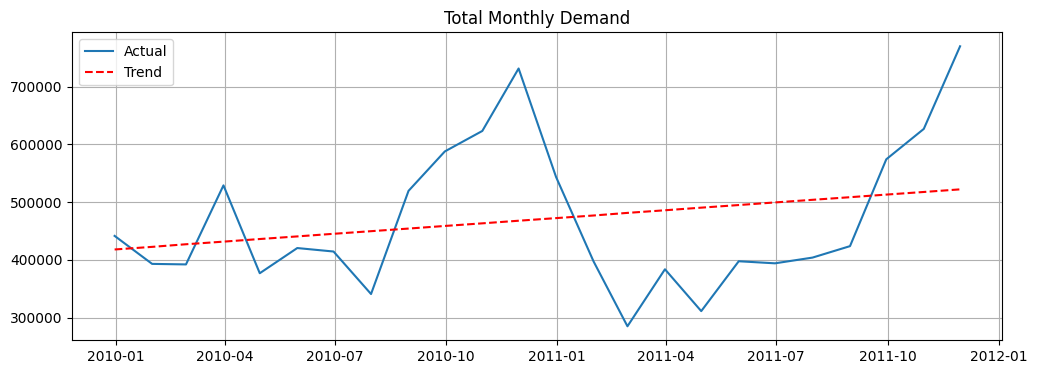

In [5]:
monthly_total = df_complete.groupby(pd.Grouper(key='ds', freq='ME'))['y'].sum()
plt.figure(figsize=(12, 4))
plt.plot(monthly_total.index, monthly_total.values, label='Actual')
x = np.arange(len(monthly_total))
z = np.polyfit(x, monthly_total.values, 1)
p = np.poly1d(z)
plt.plot(monthly_total.index, p(x), "r--", label='Trend')

plt.title('Total Monthly Demand')
plt.grid(True)
plt.legend()
plt.show()

#### Define NBEATSx parameters ahead of time for data filtering requirements

In [6]:
FORECAST_HORIZON = 90
VALIDATION_PERIOD = 90
LOOKBACK_WINDOW = 90
MIN_SERIES_LENGTH = LOOKBACK_WINDOW + VALIDATION_PERIOD

In [7]:
# Filter short time series
n_skus_before = df_complete['unique_id'].nunique()
df_complete = df_complete.groupby('unique_id').filter(lambda x: len(x) >= MIN_SERIES_LENGTH)
n_skus_after = df_complete['unique_id'].nunique()

print(f"Filtered out {n_skus_before - n_skus_after} SKUs with less than {MIN_SERIES_LENGTH} days of data")
print(f"Remaining SKUs: {n_skus_after}")

Filtered out 437 SKUs with less than 180 days of data
Remaining SKUs: 4861


#### Split the data into train test dfs

In [8]:
df_train = df_complete[df_complete.ds<df_complete['ds'].values[-90]]
df_test = df_complete[df_complete.ds>=df_complete['ds'].values[-90]].reset_index(drop=True)
print(f"Shapes:\n  Train: {df_train.shape}\n  Test:  {df_test.shape}")
print(f"Ranges:\n  Train: {df_train['ds'].min()} to {df_train['ds'].max()}\n  Test:  {df_test['ds'].min()} to {df_test['ds'].max()}")

Shapes:
  Train: (2767932, 3)
  Test:  (437490, 3)
Ranges:
  Train: 2009-12-01 00:00:00 to 2011-09-01 00:00:00
  Test:  2011-09-02 00:00:00 to 2011-11-30 00:00:00


In [9]:
model = NBEATSx(h=FORECAST_HORIZON, 
                input_size=LOOKBACK_WINDOW,
                loss=MAE(),
                scaler_type='robust',
                dropout_prob_theta=0.5,
                max_steps=200,
                val_check_steps=10,
                early_stop_patience_steps=20,
                enable_progress_bar=True)

nf = NeuralForecast(
    models=[model],
    freq='D'
)

nf.fit(df=df_train, val_size=VALIDATION_PERIOD, verbose=True)


Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]